### Ordinal Regression - binary crossentropy + metrics=['accuracy']

In [1]:
from keras.engine import Model
from keras.layers import Flatten, Dense, Input, Dropout
from keras_vggface.vggface import VGGFace
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface import utils
from keras.optimizers import Adam
from keras.preprocessing import image
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils import class_weight
import keras
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline

/home/gloria/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/gloria/tensorflow/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Constants
IMG_SIZE = 200
IMG_DIR = '../project/all_females'
RATING_PATH = './ratings_stefan.txt'
VERSION = 'v6'

In [3]:
def prepareData(percentage):
    # Load ratings
    ratings = np.genfromtxt(RATING_PATH)
    
    # Convert ratings to the desired format
    # 1. First round them
    ratings_rounded = np.round(ratings, 1).astype(np.int8)

    # 2. Then encode as suggested by Cheng (2007)
    ratings_prepared = np.zeros((len(ratings_rounded), len(np.unique(ratings_rounded))))
    for i, r in enumerate(ratings_rounded):
        for j in range(r):
            ratings_prepared[i, j] = 1
        
    # 3. Finally, make sure assignment is correct
    assert np.all(np.sum(ratings_prepared, axis=1).astype(np.int8) == ratings_rounded)
    
    ### Move all images according to ratings
    images = sorted(os.listdir(IMG_DIR))

    ### Make sure lengths of ratings and images correspond 
    assert len(ratings) == len(images)
    
    perm_ratings = np.random.permutation(len(ratings))
    test_len = int(len(ratings) * percentage/100)
    train_len = len(ratings) - test_len

    test_ind = perm_ratings[:test_len]
    train_ind = perm_ratings[test_len:]
    
    #get test & train data
    data_test = np.zeros((len(test_ind), IMG_SIZE, IMG_SIZE, 3))    
    data_train = np.zeros((len(train_ind), IMG_SIZE, IMG_SIZE, 3)) 
    last_set_train = 0
    last_set_test = 0

    for idx, _im in enumerate(images): #iterate over images
        if idx in test_ind:
            _img = image.load_img(os.path.join(IMG_DIR, _im), target_size=(IMG_SIZE,IMG_SIZE))
            _x = image.img_to_array(_img)
            _x = np.expand_dims(_x, axis=0)
            data_test[last_set_test, :, :, :] = utils.preprocess_input(_x, version=1) / .255
            last_set_test += 1
        if idx in train_ind:
            _img = image.load_img(os.path.join(IMG_DIR, _im), target_size=(IMG_SIZE,IMG_SIZE))
            _x = image.img_to_array(_img)
            _x = np.expand_dims(_x, axis=0)
            data_train[last_set_train, :, :, :] = utils.preprocess_input(_x, version=1) / .255
            last_set_train += 1
    
    
    return data_train, ratings_prepared[train_ind], data_test, ratings_prepared[test_ind], ratings_rounded

In [4]:
def getGenerator(data_train, data_test):
    train_datagen = ImageDataGenerator(rescale=1./255, 
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest',
                                preprocessing_function=utils.preprocess_input)

    train_datagen.fit(data_train)
    
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen.fit(data_test)

    return train_datagen, test_datagen

In [5]:
def visualize_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(15,8))
    plt.plot(epochs, loss, 'bo-', label="Training loss")
    plt.plot(epochs, val_loss, 'b', label="Validation loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [6]:
def visualize_acc(history):
    loss = history.history['acc']
    val_loss = history.history['val_acc']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(15,8))
    plt.plot(epochs, loss, 'ro-', label="Training acc")
    plt.plot(epochs, val_loss, 'r', label="Validation acc")
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend()
    plt.show()

In [26]:
def recommend(images, pred_classes):
    recs = np.where(pred_classes >= 4)
    
    for i in recs[0]:
        imgplot = plt.imshow(images[i])
        plt.show()
        plt.clf()

In [8]:
x_train, y_train, x_test, y_test, ratings = prepareData(5)
train_generator, test_generator = getGenerator(x_train,x_test)

(540, 200, 200, 3)

In [10]:
# Add custom layers
vgg_base = VGGFace(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), pooling='max')
last_layer = vgg_base.get_layer('global_max_pooling2d_1').output
X = Dense(256, activation='relu', name='fc6')(last_layer)
X = Dropout(0.2)(X)
X = Dense(128, activation='relu', name='fc7')(X)
X = Dropout(0.2)(X)
X = Dense(64, activation='relu', name='fc8')(X)
X = Dropout(0.2)(X)
output = Dense(len(np.unique(ratings)), activation='sigmoid')(X)
model = Model(inputs=vgg_base.input, outputs=output)

# Freeze vgg layers
for layer in vgg_base.layers:
    layer.trainable = False
    
# Compute class weights since we have unbalaned classes
class_weight = class_weight.compute_class_weight('balanced', 
                                                 np.unique(ratings), 
                                                 ratings)

model.compile(optimizer=Adam(lr= 0.0005,clipnorm=1.0),
              loss='binary_crossentropy', 
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='./weights-' + VERSION + '.hdf5', verbose=1, save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=0)

In [11]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=64),
    steps_per_epoch=540//64,
    epochs=500,
    class_weight=class_weight,
    validation_data=test_generator.flow(x_test, y_test, batch_size=64),
    callbacks=[earlystop, checkpointer]
)

Epoch 1/500
8/8 [==============================] - 11s 1s/step - loss: 0.5325 - acc: 0.7190 - val_loss: 0.4689 - val_acc: 0.7857

Epoch 00001: val_loss improved from inf to 0.46892, saving model to ./weights-v6.hdf5
Epoch 2/500
8/8 [==============================] - 5s 633ms/step - loss: 0.4814 - acc: 0.7696 - val_loss: 0.4561 - val_acc: 0.7929

Epoch 00002: val_loss improved from 0.46892 to 0.45613, saving model to ./weights-v6.hdf5
Epoch 3/500
8/8 [==============================] - 5s 677ms/step - loss: 0.4492 - acc: 0.7793 - val_loss: 0.4494 - val_acc: 0.7929

Epoch 00003: val_loss improved from 0.45613 to 0.44938, saving model to ./weights-v6.hdf5
Epoch 4/500
8/8 [==============================] - 5s 637ms/step - loss: 0.4628 - acc: 0.7690 - val_loss: 0.4496 - val_acc: 0.7857

Epoch 00004: val_loss did not improve
Epoch 5/500
8/8 [==============================] - 5s 603ms/step - loss: 0.4510 - acc: 0.7696 - val_loss: 0.4482 - val_acc: 0.7929

Epoch 00005: val_loss improved from 0.


Epoch 00043: val_loss did not improve
Epoch 44/500
8/8 [==============================] - 5s 635ms/step - loss: 0.4018 - acc: 0.8026 - val_loss: 0.4381 - val_acc: 0.7786

Epoch 00044: val_loss did not improve
Epoch 45/500
8/8 [==============================] - 5s 636ms/step - loss: 0.3933 - acc: 0.8050 - val_loss: 0.4334 - val_acc: 0.8000

Epoch 00045: val_loss did not improve
Epoch 46/500
8/8 [==============================] - 5s 634ms/step - loss: 0.3894 - acc: 0.8144 - val_loss: 0.4526 - val_acc: 0.7714

Epoch 00046: val_loss did not improve


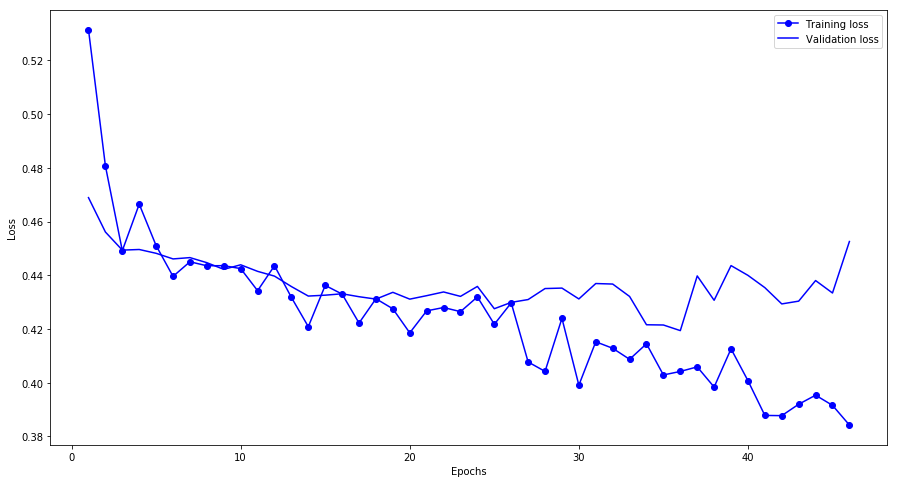

In [12]:
visualize_loss(history)

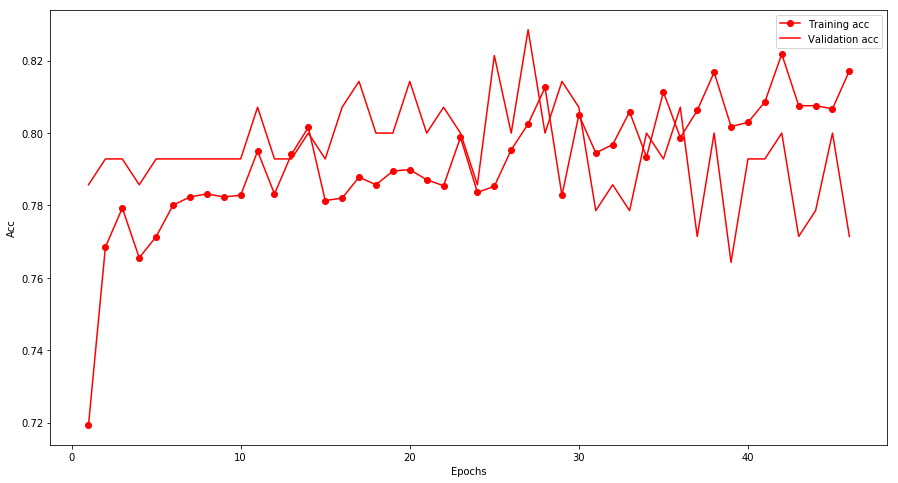

In [13]:
visualize_acc(history)

In [14]:
model.save('./models/love_classifier' + VERSION + '.h5')

In [22]:
predictions = model.predict(x_test)
print(predictions.shape)
pred_classes = predictions.sum(axis=-1)
pred_classes = np.round(pred_classes, 1).astype(np.int8)
print(pred_classes.shape)

y_true = np.array(y_test).sum(axis=-1).astype(np.int8)
print(y_true)
print(pred_classes)

confusion_matrix(y_true,pred_classes)

(28, 5)
(28,)
[4 2 0 1 3 2 1 2 3 1 0 3 2 3 0 0 0 1 0 1 4 0 1 1 2 1 1 4]
[2 2 3 1 2 3 1 2 2 2 2 1 2 3 1 2 1 0 2 3 3 2 2 2 1 2 1 2]


array([[0, 2, 4, 1, 0],
       [1, 3, 4, 1, 0],
       [0, 1, 3, 1, 0],
       [0, 1, 2, 1, 0],
       [0, 0, 2, 1, 0]])

In [27]:
recommend(x_test,pred_classes)

(array([], dtype=int64),)
